In [1]:
import sys
import os
import math
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import einops as eo

import rich
import pandas as pd
import torch_db as tdb
import toolz
import io
from scipy import interpolate
from speedrun import BaseExperiment

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline 

In [2]:
from polytax.train import Trainer
from wormulon.train_state import TrainState, NotAvailable
from wormulon.tpu.bucket import Bucket


2022-01-11 19:16:13.920709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/resolve/libs/libcudart.so.11.0
2022-01-11 19:16:13.920730: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


XLA not found No module named 'torch_xla' 



In [3]:
paths = {
    "baseline": "experiments/switch-base-8e-c4",
}

In [4]:
EXP_PATH = paths["baseline"]
exp = Trainer()
exp.experiment_directory = EXP_PATH

In [5]:
exp.read_config_file()

In [6]:
# Load from job pkl
try:
    trainstate = torch.load(open(f"{exp.experiment_directory}/Weights/trainstate-1000.pt", "rb"))
    train_state = TrainState.deserialize(io.BytesIO(trainstate))
except Exception:
    print("downloading...")
    zone = "must-results-europe"
    train_state = Bucket(zone).get_latest_trainstate(exp.experiment_directory)
    buffer = exp.train_state.serialize()
    # exp.optim = None
    path = f"{exp.experiment_directory}/Weights/trainstate-{exp.step}.pt"
    torch.save(buffer, path)

In [7]:
from transformers.optimization import Adafactor  # pylint: disable=unused-import

In [9]:
train_state.optims_state_dict = NotAvailable()

In [10]:
exp._build(train_state)

{'_wandb_group': 'base-c4', '_wandb_run_name': 'switch-base-8e-c4', 'batch_size': 4, 'dataset_name': 'c4.en', 'distributed': {'kwargs': {'backend': 'GLOO', 'rank': 0, 'world_size': 1}}, 'eval_every': 1000, 'git_rev': 'a3514605d81d5926829b56d28ccef8765dd50330', 'input_seq_len': 512, 'job': {'kwargs': {'cleanup_cmd': 'pkill -9 python3', 'env_stmts': ["export XRT_TPU_CONFIG='localservice;0;localhost:51011';", 'export PATH=$PATH:/home/$USER/.local/bin;', 'unset LD_PRELOAD;'], 'install_cmd': 'cd ~/; git clone https://github.com/mweiss17/polytax.git; pip uninstall -y wormulon; pip install -e polytax[xla];', 'setup_cmds': ['cd ~/polytax/ && git pull origin master', 'pip uninstall -y wormulon', 'pip install git+https://git@github.com/mweiss17/wormulon@main#egg=wormulon', 'pip uninstall -y transformers', 'pip install git+https://github.com/Arka161/transformers@master#egg=transformers', 'cd ~/polytax/ && pip install -e .[xla]'], 'train_cmd': 'XLA_USE_BF16=True python3 ~/polytax/src/polytax/train

wandb: Currently logged in as: mweiss10 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-11 19:16:19.349893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/resolve/libs/libcudart.so.11.0


INFO:absl:Load dataset info from gs://c4-datasets/c4/en/3.0.1
INFO:absl:Reusing dataset c4 (gs://c4-datasets/c4/en/3.0.1)
INFO:absl:Constructing tf.data.Dataset c4 for split train, from gs://c4-datasets/c4/en/3.0.1
2022-01-11 19:16:27.709971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 19:16:27.710457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 19:16:27.711169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/resolve/libs/libcudart.so.11.0
2022-01-11 19:16:27.711206: W tensorflow/stream_executor/pla

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.
INFO:absl:The output dataset from seqio.get_dataset has the following features
INFO:absl:feature: encoder_input_tokens 	 shape: [512] 	 dtype: int32
INFO:absl:feature: decoder_target_tokens 	 shape: [128] 	 dtype: int32
INFO:absl:feature: decoder_input_tokens 	 shape: [128] 	 dtype: int32
INFO:absl:feature: decoder_loss_weights 	 shape: [128] 	 dtype: int32
INFO:absl:feature: encoder_segment_ids 	 shape: [512] 	 dtype: int32
INFO:absl:feature: decoder_segment_ids 	 shape: [128] 	 dtype: int32
INFO:absl:feature: encoder_positions 	 shape: [512] 	 dtype: int32
INFO:absl:feature: decoder_positions 	 shape: [128] 	 dtype: int32


building dataset.


/home/martin/code/transformers/src/transformers/configuration_utils.py:340: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [11]:
# Get samples
sample = next(exp.train_loader)

2022-01-11 19:28:11.576479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-11 19:28:11.576525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-01-11 19:28:11.576536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3 of 1000
2022-01-11 19:28:11.576545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4 of 1000
2022-01-11 19:28:11.576554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 5 of 1000
2022-01-11 19:28:11.576562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6 of 1000
2022-01-11 19:28:11.576570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this 

In [19]:
def cosd_matrix(x): 
    # x.shape = ...NC
    norms = torch.norm(x, dim=-1, p=2)
    cosd = torch.einsum("...mc,...nc->...mn", x, x) / torch.einsum("...m,...n->...mn", norms, norms)
    return cosd

In [20]:
@torch.no_grad()
def get_param_norm(m): 
    if len(list(m.parameters())) == 0:
        return torch.tensor(0.)
    all_params = torch.cat([p.reshape(-1) for p in m.parameters()])
    return torch.norm(all_params)


@torch.no_grad()
def get_grad_norm(m, normalize=False): 
    if len(list(m.parameters())) == 0:
        return torch.tensor(0.)
    all_params = torch.cat([p.grad.reshape(-1) for p in m.parameters()])
    if not normalize:
        return torch.norm(all_params)
    else: 
        num_params = sum([p.numel() for p in m.parameters()])
        return torch.norm(all_params) / (num_params ** 0.5)

In [21]:
def get_image(model_input, normalize=True): 
    image = model_input["image"]
    if image.dim() == 5:
        image = image[:, 0]
    image = tf.normalize(image, 
                         mean=timm.data.constants.IMAGENET_DEFAULT_MEAN, 
                         std=timm.data.constants.IMAGENET_DEFAULT_STD)
    return image
    

In [22]:
@torch.no_grad()
def validate(model, loader, device="cuda:0"): 
    model = deepcopy(model)
    model.to(device)
    
    hits = 0
    total = 0
    
    for sample in loader: 
        image = get_image(sample).to(device)
        label = sample["label"].to(device)
        
        output = model(image)
        hits += output.argmax(-1).eq(label).sum().item()
        total += output.shape[0]
        print(hits / total)
    
    return hits / total

In [23]:
@torch.no_grad()
def validate_native(model, loader, device="cuda:0"): 
    model = deepcopy(model)
    model.to(device)
    
    hits = 0
    total = 0
    
    for model_input in loader: 
        model_input = to_device(model_input, device)
        model_output = model(model_input)
        output = model_output["task_outputs/head_output"]
        label = model_input["label"]
        
        hits += output.argmax(-1).eq(label).sum().item()
        total += output.shape[0]
        print(hits / total)
    
    return hits / total

### Prep the Model

In [24]:
# model = unshare_perceving_blocks(model)

In [113]:
model.cpu()
model.eval()
loss_fn = exp.objective.losses["TaskClassificationLoss"]

with tdb.Tracer().trace(model) as tracer: 
    model_output = model(model_input)
    loss = loss_fn(model_input, model_output)
    loss["loss"].backward()
    

/private/home/nasimrahaman/.conda/envs/th1938/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/private/home/nasimrahaman/.conda/envs/th1938/lib/python3.8/site-packages/torch/nn/modules/module.py:939: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/private/home/nasimrahaman/.conda/envs/th1938/lib/py

## Rebuild the Model

In [19]:
tracer = torch.load("tracer_records.pt")

In [23]:
router_keys = []
for key in tracer.keys():
    if "router_linear" in key:
        router_keys.append(key)

In [24]:
for key in router_keys:
    print(tracer[key])

{'input': [tensor([[[ 5.6524e-02, -1.5308e-01, -1.2457e-04,  ...,  1.0178e-01,
           1.1383e-01, -2.4118e-02],
         [-1.5520e-02, -1.9332e-01,  4.5586e-02,  ...,  2.3591e-01,
           7.0960e-02,  1.2749e-02],
         [ 5.0771e-02, -1.8228e-01, -5.4100e-03,  ..., -1.1519e-01,
           1.7854e-02,  1.0192e-01],
         ...,
         [-8.8633e-02, -2.5445e-01,  3.2638e-02,  ...,  4.8649e-02,
          -1.2245e-02, -3.0421e-02],
         [ 1.5463e-01, -9.4091e-06, -1.7988e-02,  ...,  7.4240e-02,
           7.4270e-02,  4.0413e-02],
         [-4.9908e-02, -7.5502e-02, -5.9646e-02,  ..., -3.4051e-03,
          -1.5979e-02,  3.7074e-02]]])], 'output': tensor([[[-2.9891e-02],
         [ 1.6429e-02],
         [ 6.2306e-02],
         [ 4.9346e-02],
         [ 4.9591e-02],
         [-1.0663e-02],
         [ 4.5608e-02],
         [ 4.6902e-02],
         [ 8.9895e-02],
         [-4.2781e-02],
         [-3.6174e-03],
         [-6.0308e-02],
         [ 3.5726e-02],
         [-1.2564e-

### Correlations between Latents

In [71]:
act_norm_l0 = torch.norm(act_l0, dim=-1, p=2)
act_cosd_l0 = torch.einsum("...mc,...nc->...mn", act_l0, act_l0) / torch.einsum("...m,...n->...mn", act_norm_l0, act_norm_l0)

tril_mask = torch.tril(torch.ones(act_cosd_l0.shape[-2:], dtype=torch.bool), diagonal=-1)
act_trilcosd_l0 = act_cosd_l0[:, :, tril_mask]

In [72]:
act_avgcosd_l0 = act_cosd_l0.mean(1)

In [73]:
act_l0_normed = act_l0 / act_norm_l0[..., None]

In [74]:
act_bcosd_l0 = torch.einsum("lanc,lbnc->lnab", act_l0_normed, act_l0_normed)
act_avgbcosd_l0 = act_bcosd_l0.mean(1)

In [75]:
for l in range(act_trilcosd_l0.shape[0]): 
    print(f"Layer {l}: ", act_trilcosd_l0[l].mean())

Layer 0:  tensor(0.7738)
Layer 1:  tensor(0.8834)
Layer 2:  tensor(0.8960)
Layer 3:  tensor(0.9042)
Layer 4:  tensor(0.8853)
Layer 5:  tensor(0.9142)
Layer 6:  tensor(0.8037)
Layer 7:  tensor(0.8446)
Layer 8:  tensor(0.8532)
Layer 9:  tensor(0.8466)
Layer 10:  tensor(0.8489)
Layer 11:  tensor(0.8432)
Layer 12:  tensor(0.8120)
Layer 13:  tensor(0.8153)
Layer 14:  tensor(0.8107)
Layer 15:  tensor(0.8065)
Layer 16:  tensor(0.8035)
Layer 17:  tensor(0.8049)
Layer 18:  tensor(0.7651)
Layer 19:  tensor(0.7640)
Layer 20:  tensor(0.7551)
Layer 21:  tensor(0.7478)
Layer 22:  tensor(0.7402)
Layer 23:  tensor(0.7320)
Layer 24:  tensor(0.7003)
Layer 25:  tensor(0.6841)
Layer 26:  tensor(0.6651)
Layer 27:  tensor(0.6393)
Layer 28:  tensor(0.6111)
Layer 29:  tensor(0.5634)


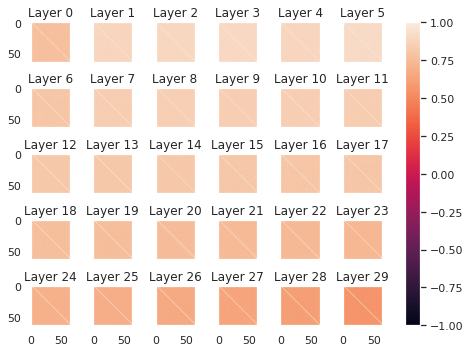

In [76]:
shape = (5, 6)

fig, axs = plt.subplots(shape[0], shape[1], sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgcosd_l0.shape[0]): 
    i, j = np.unravel_index(l, shape)
    imsh = axs[i, j].imshow(act_avgcosd_l0[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

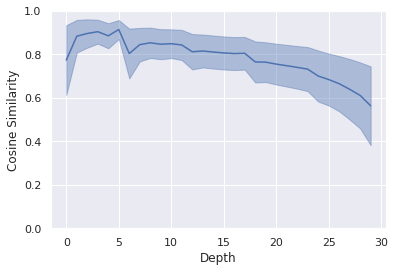

In [77]:
ls = list(range(act_trilcosd_l0.shape[0]))
mean_cosd = [act_trilcosd_l0[l].mean().item() for l in ls]
std_cosd = [act_trilcosd_l0[l].std().item() for l in ls]

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mean_cosd, c=cpal[0])
plt.fill_between(ls, 
                 [mu - sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 [mu + sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 alpha=0.4, color=cpal[0])
plt.xlabel("Depth")
plt.ylabel("Cosine Similarity")
plt.ylim((0, 1))
# plt.title("Perceiver")
plt.show()

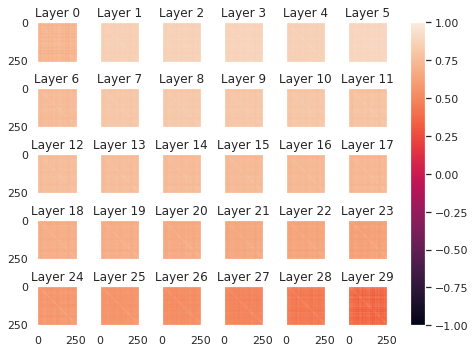

In [78]:
shape = (5, 6)

fig, axs = plt.subplots(shape[0], shape[1], sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgbcosd_l0.shape[0]): 
    i, j = np.unravel_index(l, shape)
    imsh = axs[i, j].imshow(act_avgbcosd_l0[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

In [79]:
btril_mask = torch.tril(torch.ones(act_avgbcosd_l0.shape[-2:], dtype=torch.bool), diagonal=-1)
act_trilbcosd_l0 = act_bcosd_l0[:, :, btril_mask]

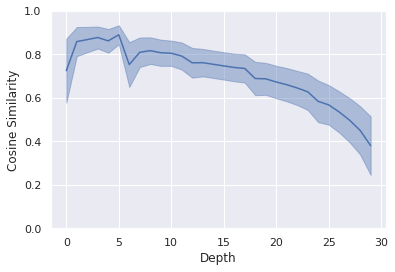

In [81]:
ls = list(range(act_trilbcosd_l0.shape[0]))
mean_cosd = [act_trilbcosd_l0[l].mean().item() for l in ls]
std_cosd = [act_trilbcosd_l0[l].std().item() for l in ls]

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mean_cosd, c=cpal[0])
plt.fill_between(ls, 
                 [mu - sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 [mu + sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 alpha=0.4, color=cpal[0])
plt.xlabel("Depth")
plt.ylabel("Cosine Similarity")
plt.ylim((0, 1))
# plt.title("Perceiver")
plt.show()

In [45]:
rich.print(list(tracer.records.keys()))

[
    'preprocessor.image_preprocessor.0',
    'preprocessor.image_preprocessor.1',
    'preprocessor.image_preprocessor.2',
    'preprocessor.image_preprocessor.3',
    'preprocessor.image_preprocessor',
    'preprocessor.mask_preprocessor',
    'preprocessor',
    'positional_encoder.row_encoder.0',
    'positional_encoder.row_encoder.1',
    'positional_encoder.row_encoder.2',
    'positional_encoder.row_encoder',
    'positional_encoder.col_encoder.0',
    'positional_encoder.col_encoder.1',
    'positional_encoder.col_encoder.2',
    'positional_encoder.col_encoder',
    'positional_encoder.dropout',
    'positional_encoder',
    'masker',
    'latent_generator',
    'perceiving_blocks.0.input_attention.attention.norm',
    'perceiving_blocks.0.input_attention.attention.norm_context',
    'perceiving_blocks.0.input_attention.attention.fn.to_q',
    'perceiving_blocks.0.input_attention.attention.fn.to_kv',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.v',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.sim',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.attn',
    'perceiving_blocks.0.input_attention.attention.fn.to_out.0',
    'perceiving_blocks.0.input_attention.attention.fn.to_out.1',
    'perceiving_blocks.0.input_attention.attention.fn.to_out',
    'perceiving_blocks.0.input_attention.attention.fn',
    'perceiving_blocks.0.input_attention.attention',
    'perceiving_blocks.0.input_attention.ffn.norm',
    'perceiving_blocks.0.input_attention.ffn.fn.net.0',
    'perceiving_blocks.0.input_attention.ffn.fn.net.1',
    'perceiving_blocks.0.input_attention.ffn.fn.net.2',
    'perceiving_blocks.0.input_attention.ffn.fn.net.3',
    'perceiving_blocks.0.input_attention.ffn.fn.net',
    'perceiving_blocks.0.input_attention.ffn.fn',
    'perceiving_blocks.0.input_attention.ffn',
    'perceiving_blocks.0.input_attention',
    'perceiving_blocks.0.latent_attention_layers.0.attention.norm',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_q',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_kv',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.v',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.sim',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.attn',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out.0',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out.1',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn',
    'perceiving_blocks.0.latent_attention_layers.0.attention',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.norm',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.0',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.1',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.2',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.3',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn',
    'perceiving_blocks.0.latent_attention_layers.0.ffn',
    'perceiving_blocks.0.latent_attention_layers.0',
    'perceiving_blocks.0.latent_attention_layers.1.attention.norm',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.to_q',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.to_kv',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.l

### Evolution of Latents

In [99]:
act_l1 = act_l0.clone()

In [100]:
proj_mat = torch.randn(256, 2)
projact_l1 = act_l1 @ proj_mat

In [101]:
proj_mat_1d = torch.randn(256, 1)
projact_1d_l1 = (act_l1 @ proj_mat_1d)[..., 0]

In [89]:
def splinify(x, **kwargs): 
    # x.shape = N2
    if torch.is_tensor(x): 
        x = x.numpy()
    a = x[:, 0]
    b = x[:, 1]
    tck, u = interpolate.splprep([a, b], **kwargs)
    unew = np.arange(0, 1.01, 0.01)
    out = interpolate.splev(unew, tck)
    return np.stack(out, axis=-1)

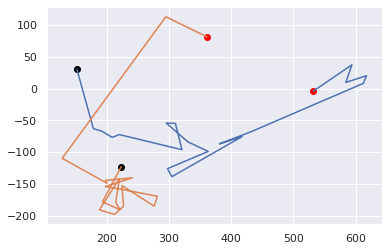

In [613]:
cpal = sns.color_palette(n_colors=64)

plt.figure()
for n in range(2): 
    traj = projact_l1[:, 0, n, :] 
    # spl = splinify(traj, s=10)
    spl = traj
    plt.plot(spl[:, 0], spl[:, 1], c=cpal[n])
    plt.scatter(traj[0, 0], traj[0, 1], c="black")
    plt.scatter(traj[-1, 0], traj[-1, 1], c="red")
plt.show()

In [83]:
cpal = sns.color_palette(n_colors=64)

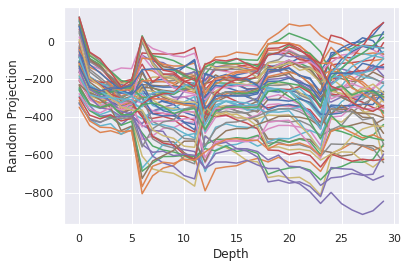

In [102]:
plt.figure()
for n in range(64): 
    plt.plot(projact_1d_l1[:, 0, n])
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

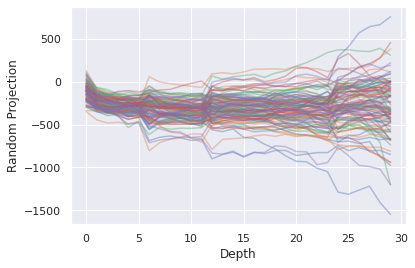

In [103]:
plt.figure()
for n in range(0, 5): 
    for b in range(20): 
        plt.plot(projact_1d_l1[:, b, n], c=cpal[n], alpha=0.4)
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

In [93]:
with torch.no_grad():
    act_with_latent_l1 = torch.cat([eo.repeat(model.latent_generator.latents, "n c -> () b n c", b=act_l1.shape[1]), act_l1], dim=0)
    act_diff_l1 = torch.diff(act_with_latent_l1, dim=0)

AttributeError: 'GaussianLatents' object has no attribute 'latents'

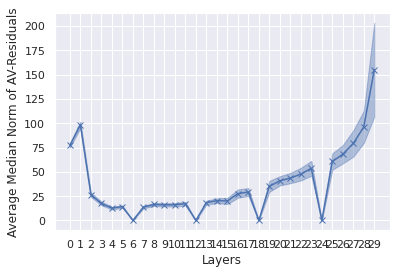

In [354]:
mu = act_diff_l1.norm(p=2, dim=-1).median(-1).values.mean(-1)
sig = act_diff_l1.norm(p=2, dim=-1).median(-1).values.std(-1)
ls = list(range(act_diff_l1.shape[0]))

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mu, c=cpal[0], marker="x")
plt.fill_between(ls, mu - sig, mu + sig, color=cpal[0], alpha=0.4)
plt.xticks(ls)
plt.xlabel("Layers")
plt.ylabel("Average Median Norm of AV-Residuals")
plt.show()

### Looking at Gradients

In [94]:
grad_l2 = []

for block in range(len(model.perceiving_blocks)): 
    print(f"Layer {len(grad_l2)}: Input  (Block {block})")
    grad_l2.append(tracer.get(f"perceiving_blocks.{block}.input_attention", "grad_output")[0])
    for lattn in range(len(model.perceiving_blocks[0].latent_attention_layers)): 
        print(f"Layer {len(grad_l2)}: Latent (Block {block} / Layer {lattn})")
        grad_l2.append(tracer.get(f"perceiving_blocks.{block}.latent_attention_layers.{lattn}", "grad_output")[0])


Layer 0: Input  (Block 0)
Layer 1: Latent (Block 0 / Layer 0)
Layer 2: Latent (Block 0 / Layer 1)
Layer 3: Latent (Block 0 / Layer 2)
Layer 4: Latent (Block 0 / Layer 3)
Layer 5: Latent (Block 0 / Layer 4)
Layer 6: Input  (Block 1)
Layer 7: Latent (Block 1 / Layer 0)
Layer 8: Latent (Block 1 / Layer 1)
Layer 9: Latent (Block 1 / Layer 2)
Layer 10: Latent (Block 1 / Layer 3)
Layer 11: Latent (Block 1 / Layer 4)
Layer 12: Input  (Block 2)
Layer 13: Latent (Block 2 / Layer 0)
Layer 14: Latent (Block 2 / Layer 1)
Layer 15: Latent (Block 2 / Layer 2)
Layer 16: Latent (Block 2 / Layer 3)
Layer 17: Latent (Block 2 / Layer 4)
Layer 18: Input  (Block 3)
Layer 19: Latent (Block 3 / Layer 0)
Layer 20: Latent (Block 3 / Layer 1)
Layer 21: Latent (Block 3 / Layer 2)
Layer 22: Latent (Block 3 / Layer 3)
Layer 23: Latent (Block 3 / Layer 4)
Layer 24: Input  (Block 4)
Layer 25: Latent (Block 4 / Layer 0)
Layer 26: Latent (Block 4 / Layer 1)
Layer 27: Latent (Block 4 / Layer 2)
Layer 28: Latent (Block 

In [95]:
grad_l2 = torch.stack(grad_l2)

In [357]:
grad_l2.norm(p=2, dim=(1, 2, 3))

tensor([0.1187, 0.0310, 0.0293, 0.0264, 0.0244, 0.0226, 0.0226, 0.0211, 0.0184,
        0.0170, 0.0152, 0.0134, 0.0134, 0.0123, 0.0112, 0.0103, 0.0091, 0.0080,
        0.0080, 0.0072, 0.0063, 0.0056, 0.0050, 0.0045, 0.0045, 0.0039, 0.0034,
        0.0029, 0.0025, 0.0019])

ValueError: x and y must have same first dimension, but have shapes (20,) and torch.Size([30])

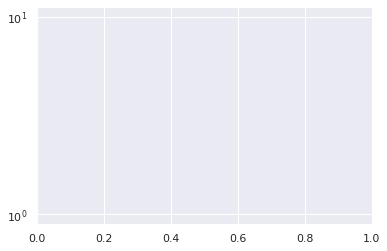

In [151]:
plt.figure()
plt.semilogy(list(range(20)), grad_l2.norm(p=2, dim=(1, 2, 3)), marker="x")
plt.xticks(ticks=list(range(20)))
plt.show()

In [96]:
pgrads_l2 = []

for b in range(len(model.perceiving_blocks)): 
    pgrads_l2.append(get_grad_norm(model.perceiving_blocks[b].input_attention, True))
    for l in range(len(model.perceiving_blocks[0].latent_attention_layers)):
        pgrads_l2.append(get_grad_norm(model.perceiving_blocks[b].latent_attention_layers[l], True))

pgrads_l2 = torch.stack(pgrads_l2)

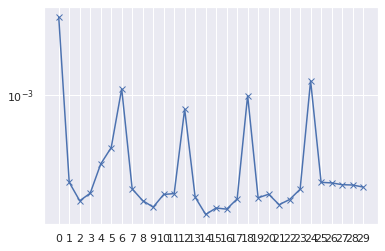

In [97]:
plt.figure()
plt.semilogy(list(range(pgrads_l2.shape[0])), pgrads_l2, marker="x")
plt.xticks(ticks=list(range(pgrads_l2.shape[0])))
plt.show()

In [98]:
# get_grad_norm(model.perceiving_blocks[0].input_attention.attention.fn.to_kv)
# get_grad_norm(model.perceiving_blocks[0].latent_attention_layers[0])

In [19]:
rich.print(list(tracer.records.keys()))

[
    'preprocessor.image_preprocessor.0',
    'preprocessor.image_preprocessor.1',
    'preprocessor.image_preprocessor.2',
    'preprocessor.image_preprocessor.3',
    'preprocessor.image_preprocessor',
    'preprocessor.mask_preprocessor',
    'preprocessor',
    'positional_encoder.row_encoder.0',
    'positional_encoder.row_encoder.1',
    'positional_encoder.row_encoder.2',
    'positional_encoder.row_encoder',
    'positional_encoder.col_encoder.0',
    'positional_encoder.col_encoder.1',
    'positional_encoder.col_encoder.2',
    'positional_encoder.col_encoder',
    'positional_encoder.dropout',
    'positional_encoder',
    'masker',
    'latent_generator',
    'perceiving_blocks.0.input_attention.attention.norm',
    'perceiving_blocks.0.input_attention.attention.norm_context',
    'perceiving_blocks.0.input_attention.attention.fn.to_q',
    'perceiving_blocks.0.input_attention.attention.fn.to_kv',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.v',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.sim',
    'perceiving_blocks.0.input_attention.attention.fn.tracer_probes.attn',
    'perceiving_blocks.0.input_attention.attention.fn.to_out.0',
    'perceiving_blocks.0.input_attention.attention.fn.to_out.1',
    'perceiving_blocks.0.input_attention.attention.fn.to_out',
    'perceiving_blocks.0.input_attention.attention.fn',
    'perceiving_blocks.0.input_attention.attention',
    'perceiving_blocks.0.input_attention.ffn.norm',
    'perceiving_blocks.0.input_attention.ffn.fn.net.0',
    'perceiving_blocks.0.input_attention.ffn.fn.net.1',
    'perceiving_blocks.0.input_attention.ffn.fn.net.2',
    'perceiving_blocks.0.input_attention.ffn.fn.net.3',
    'perceiving_blocks.0.input_attention.ffn.fn.net',
    'perceiving_blocks.0.input_attention.ffn.fn',
    'perceiving_blocks.0.input_attention.ffn',
    'perceiving_blocks.0.input_attention',
    'perceiving_blocks.0.latent_attention_layers.0.attention.norm',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_q',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_kv',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.v',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.sim',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.tracer_probes.attn',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out.0',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out.1',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn.to_out',
    'perceiving_blocks.0.latent_attention_layers.0.attention.fn',
    'perceiving_blocks.0.latent_attention_layers.0.attention',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.norm',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.0',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.1',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.2',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net.3',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn.net',
    'perceiving_blocks.0.latent_attention_layers.0.ffn.fn',
    'perceiving_blocks.0.latent_attention_layers.0.ffn',
    'perceiving_blocks.0.latent_attention_layers.0',
    'perceiving_blocks.0.latent_attention_layers.1.attention.norm',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.to_q',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.to_kv',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.tracer_probes.q',
    'perceiving_blocks.0.latent_attention_layers.1.attention.fn.tracer_probes.k',
    'perceiving_blocks.0.l

### Off-the-shelf ViT

In [489]:
import timm

In [490]:
vit = timm.models.deit_small_patch16_224(pretrained=False)

In [491]:
# vit

In [492]:
# vit.core

In [493]:
# print(validate(vit, exp.validation_loader))

In [494]:
image = get_image(model_input)

In [495]:
image = image.cpu()
vit = vit.cpu()

In [496]:
with torch.no_grad():
    with tdb.Tracer().trace(vit) as tracer_vit: 
        out = vit(image)

In [497]:
act_l3 = [tracer_vit.get(f"blocks.{l}", "output") for l in range(12)]

In [498]:
act_l3 = torch.stack(act_l3)

In [499]:
df = []

for seed in range(1000): 
    proj_mat = torch.randn(384, 1)
    projact_l3 = (act_l3 @ proj_mat)[..., 0]
    for layer in range(projact_l3.shape[0]):
        cctril = np.tril(np.corrcoef(projact_l3[layer].t()), -1)
        # cctril = np.tril(np.corrcoef(torch.randn_like(projact_l3[layer]).t()), -1)
        df.append({"seed": seed, "layer": layer, "cc": cctril[cctril != 0].mean()})

df = pd.DataFrame(df)

In [500]:
df_l3 = df

(0.0, 1.0)

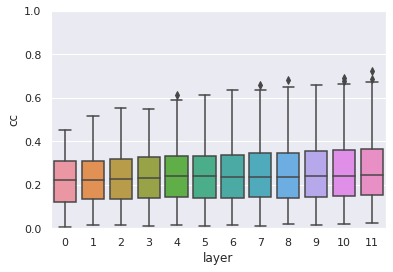

In [501]:
sns.boxplot(x="layer", y="cc", data=df_l3)
plt.ylim((0, 1))

(0.0, 1.0)

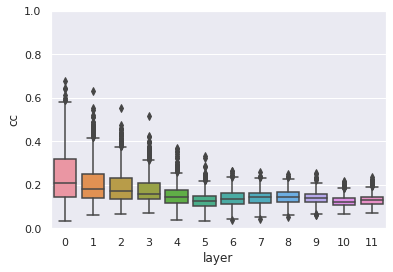

In [400]:
sns.boxplot(x="layer", y="cc", data=df_l3)
plt.ylim((0, 1))

In [131]:
act_norm_l3 = torch.norm(act_l3, dim=-1, p=2)
act_cosd_l3 = torch.einsum("...mc,...nc->...mn", act_l3, act_l3) / torch.einsum("...m,...n->...mn", act_norm_l3, act_norm_l3)

tril_mask = torch.tril(torch.ones(act_cosd_l3.shape[-2:], dtype=torch.bool), diagonal=-1)
act_trilcosd_l3 = act_cosd_l3[:, :, tril_mask]

In [151]:
act_avgcosd_l3 = act_cosd_l3.mean(1)

In [321]:
act_l3_normed = act_l3 / act_norm_l3[..., None]

In [324]:
act_bcosd_l3 = torch.einsum("lanc,lbnc->lnab", act_l3_normed, act_l3_normed)
act_avgbcosd_l3 = act_bcosd_l3.mean(1)

In [132]:
for l in range(act_trilcosd_l3.shape[0]): 
    print(f"Layer {l}: ", act_trilcosd_l3[l].mean())

Layer 0:  tensor(0.4065)
Layer 1:  tensor(0.3397)
Layer 2:  tensor(0.2858)
Layer 3:  tensor(0.2743)
Layer 4:  tensor(0.2776)
Layer 5:  tensor(0.2641)
Layer 6:  tensor(0.2894)
Layer 7:  tensor(0.3214)
Layer 8:  tensor(0.3309)
Layer 9:  tensor(0.3426)
Layer 10:  tensor(0.3514)
Layer 11:  tensor(0.3053)


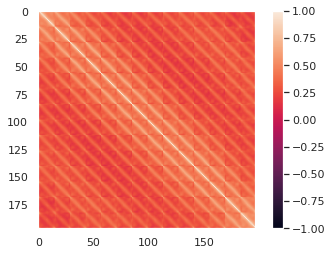

In [149]:
plt.figure()
plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
plt.grid(False)
plt.colorbar()
plt.show()

In [150]:
np.unravel_index(3, (3, 4))

(0, 3)

In [152]:
act_avgcosd_l3.shape

torch.Size([12, 197, 197])

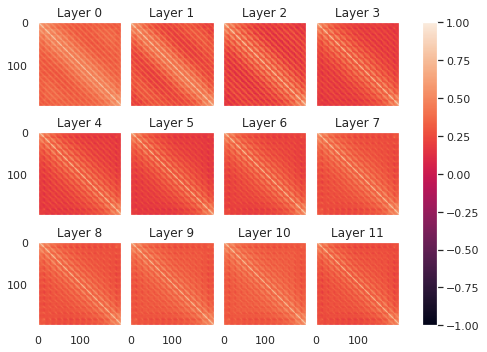

In [164]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgcosd_l3.shape[0]): 
    i, j = np.unravel_index(l, (3, 4))
    imsh = axs[i, j].imshow(act_avgcosd_l3[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

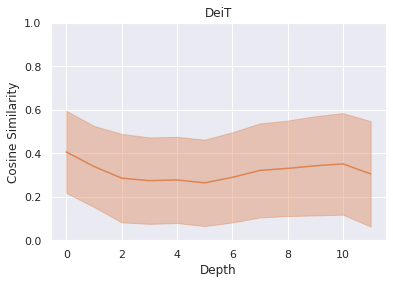

In [174]:
ls = list(range(act_trilcosd_l3.shape[0]))
mean_cosd = [act_trilcosd_l3[l].mean().item() for l in ls]
std_cosd = [act_trilcosd_l3[l].std().item() for l in ls]

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mean_cosd, c=cpal[1])
plt.fill_between(ls, 
                 [mu - sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 [mu + sigma for mu, sigma in zip(mean_cosd, std_cosd)], 
                 alpha=0.4, color=cpal[1])
plt.xlabel("Depth")
plt.ylabel("Cosine Similarity")
plt.ylim((0, 1))
plt.title("DeiT")
plt.show()

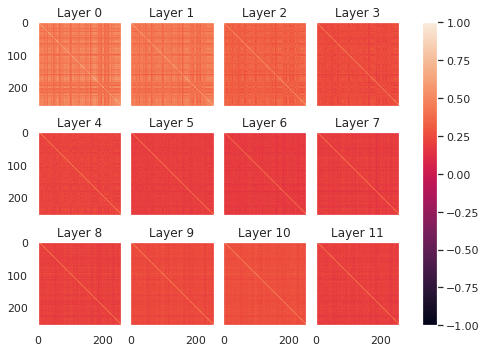

In [325]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgbcosd_l3.shape[0]): 
    i, j = np.unravel_index(l, (3, 4))
    imsh = axs[i, j].imshow(act_avgbcosd_l3[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

In [407]:
vit.cls_token.shape

torch.Size([1, 1, 384])

In [408]:
vit_latent_l3 = torch.cat([eo.repeat(vit.cls_token[0], "... -> b ...", b=act_l4.shape[1]), 
                           tracer_vit.get("patch_embed", "output")], dim=1)

In [409]:
with torch.no_grad():
    act_with_latent_l3 = torch.cat([vit_latent_l3[None], act_l3], dim=0)
    act_diff_l3 = torch.diff(act_with_latent_l3, dim=0)

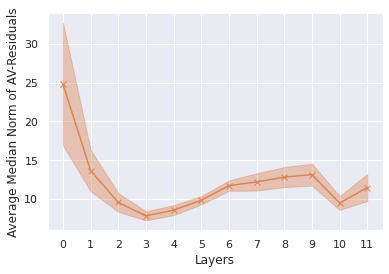

In [410]:
mu = act_diff_l3.norm(p=2, dim=-1).median(-1).values.mean(-1)
sig = act_diff_l3.norm(p=2, dim=-1).median(-1).values.std(-1)
ls = list(range(act_diff_l3.shape[0]))

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mu, c=cpal[1], marker="x")
plt.fill_between(ls, mu - sig, mu + sig, color=cpal[1], alpha=0.4)
plt.xticks(ls)
plt.xlabel("Layers")
plt.ylabel("Average Median Norm of AV-Residuals")
plt.show()

In [502]:
proj_mat_1d = torch.randn(384, 1)
projact_1d_l3 = (act_l3 @ proj_mat_1d)[..., 0]

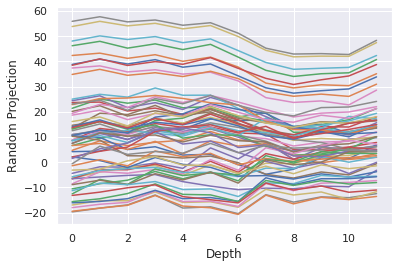

In [511]:
plt.figure()
for n in range(64): 
    plt.plot(projact_1d_l3[:, 1, n])
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

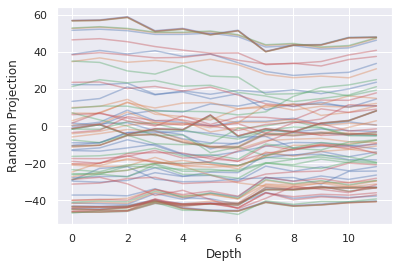

In [508]:
plt.figure()
for n in range(10, 14): 
    for b in range(20): 
        plt.plot(projact_1d_l3[:, b, n], c=cpal[n], alpha=0.4)
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

In [401]:
rich.print(list(tracer_vit.records.keys()))

[
    'patch_embed.proj',
    'patch_embed.norm',
    'patch_embed',
    'pos_drop',
    'blocks.0.norm1',
    'blocks.0.attn.qkv',
    'blocks.0.attn.attn_drop',
    'blocks.0.attn.proj',
    'blocks.0.attn.proj_drop',
    'blocks.0.attn',
    'blocks.0.drop_path',
    'blocks.0.norm2',
    'blocks.0.mlp.fc1',
    'blocks.0.mlp.act',
    'blocks.0.mlp.drop',
    'blocks.0.mlp.fc2',
    'blocks.0.mlp',
    'blocks.0',
    'blocks.1.norm1',
    'blocks.1.attn.qkv',
    'blocks.1.attn.attn_drop',
    'blocks.1.attn.proj',
    'blocks.1.attn.proj_drop',
    'blocks.1.attn',
    'blocks.1.drop_path',
    'blocks.1.norm2',
    'blocks.1.mlp.fc1',
    'blocks.1.mlp.act',
    'blocks.1.mlp.drop',
    'blocks.1.mlp.fc2',
    'blocks.1.mlp',
    'blocks.1',
    'blocks.2.norm1',
    'blocks.2.attn.qkv',
    'blocks.2.attn.attn_drop',
    'blocks.2.attn.proj',
    'blocks.2.attn.proj_drop',
    'blocks.2.attn',
    'blocks.2.drop_path',
    'blocks.2.norm2',
    'blocks.2.mlp.fc1',
    'blocks.2.mlp.act',
    'blocks.2.mlp.drop',
    'blocks.2.mlp.fc2',
    'blocks.2.mlp',
    'blocks.2',
    'blocks.3.norm1',
    'blocks.3.attn.qkv',
    'blocks.3.attn.attn_drop',
    'blocks.3.attn.proj',
    'blocks.3.attn.proj_drop',
    'blocks.3.attn',
    'blocks.3.drop_path',
    'blocks.3.norm2',
    'blocks.3.mlp.fc1',
    'blocks.3.mlp.act',
    'blocks.3.mlp.drop',
    'blocks.3.mlp.fc2',
    'blocks.3.mlp',
    'blocks.3',
    'blocks.4.norm1',
    'blocks.4.attn.qkv',
    'blocks.4.attn.attn_drop',
    'blocks.4.attn.proj',
    'blocks.4.attn.proj_drop',
    'blocks.4.attn',
    'blocks.4.drop_path',
    'blocks.4.norm2',
    'blocks.4.mlp.fc1',
    'blocks.4.mlp.act',
    'blocks.4.mlp.drop',
    'blocks.4.mlp.fc2',
    'blocks.4.mlp',
    'blocks.4',
    'blocks.5.norm1',
    'blocks.5.attn.qkv',
    'blocks.5.attn.attn_drop',
    'blocks.5.attn.proj',
    'blocks.5.attn.proj_drop',
    'blocks.5.attn',
    'blocks.5.drop_path',
    'blocks.5.norm2',
    'blocks.5.mlp.fc1',
    'blocks.5.mlp.act',
    'blocks.5.mlp.drop',
    'blocks.5.mlp.fc2',
    'blocks.5.mlp',
    'blocks.5',
    'blocks.6.norm1',
    'blocks.6.attn.qkv',
    'blocks.6.attn.attn_drop',
    'blocks.6.attn.proj',
    'blocks.6.attn.proj_drop',
    'blocks.6.attn',
    'blocks.6.drop_path',
    'blocks.6.norm2',
    'blocks.6.mlp.fc1',
    'blocks.6.mlp.act',
    'blocks.6.mlp.drop',
    'blocks.6.mlp.fc2',
    'blocks.6.mlp',
    'blocks.6',
    'blocks.7.norm1',
    'blocks.7.attn.qkv',
    'blocks.7.attn.attn_drop',
    'blocks.7.attn.proj',
    'blocks.7.attn.proj_drop',
    'blocks.7.attn',
    'blocks.7.drop_path',
    'blocks.7.norm2',
    'blocks.7.mlp.fc1',
    'blocks.7.mlp.act',
    'blocks.7.mlp.drop',
    'blocks.7.mlp.fc2',
    'blocks.7.mlp',
    'blocks.7',
    'blocks.8.norm1',
    'blocks.8.attn.qkv',
    'blocks.8.attn.attn_drop',
    'blocks.8.attn.proj',
    'blocks.8.attn.proj_drop',
    'blocks.8.attn',
    'blocks.8.drop_path',
    'blocks.8.norm2',
    'blocks.8.mlp.fc1',
    'blocks.8.mlp.act',
    'blocks.8.mlp.drop',
    'blocks.8.mlp.fc2',
    'blocks.8.mlp',
    'blocks.8',
    'blocks.9.norm1',
    'blocks.9.attn.qkv',
    'blocks.9.attn.attn_drop',
    'blocks.9.attn.proj',
    'blocks.9.attn.proj_drop',
    'blocks.9.attn',
    'blocks.9.drop_path',
    'blocks.9.norm2',
    'blocks.9.mlp.fc1',
    'blocks.9.mlp.act',
    'blocks.9.mlp.drop',
    'blocks.9.mlp.fc2',
    'blocks.9.mlp',
    'blocks.9',
    'blocks.10.norm1',
    'blocks.10.attn.qkv',
    'blocks.10.attn.attn_drop',
    'blocks.10.attn.proj',
    'blocks.10.attn.proj_drop',
    'blocks.10.attn',
    'blocks.10.drop_path',
    'blocks.10.norm2',
    'blocks.10.mlp.fc1',
    'blocks.10.mlp.act',
    'blocks.10.mlp.drop',
    'blocks.10.mlp.fc2',
    'blocks.10.mlp',
    'blocks.10',
    'blocks.11.norm1',
    'blocks.11.attn.qkv',
    'blocks.11.attn.attn_drop',
    'blocks.11.attn.proj',
    'blocks.11.attn.proj_drop',
    'blocks.11.attn',
    'blocks.11.drop_path',
    '

### Native ViTs

In [433]:
vit_exp = PKABUTrainer("none")
vit_exp.experiment_directory = paths["vit"]
vit_exp.read_config_file()

In [434]:
vit_exp._build_objective()

In [435]:
vit_exp._build_loaders()

In [436]:
vit = ViT(**vit_exp.get("model/kwargs"))

In [437]:
os.listdir(vit_exp.checkpoint_directory)[-2]

'ckpt_epoch_199.pt'

In [438]:
ckpt = torch.load(os.path.join(vit_exp.checkpoint_directory, "ckpt_iter_0.pt"), map_location="cpu")
vit.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [439]:
torch.cuda.empty_cache()
# validate_native(vit, vit_exp.validation_loader)

In [440]:
vit.cpu()
vit.train()
loss_fn = vit_exp.objective.losses["TaskClassificationLoss"]

with tdb.Tracer().trace(vit) as vit_tracer: 
    vit_output = vit(model_input)
    loss = loss_fn(model_input, vit_output)
    loss["loss"].backward()


/private/home/nasimrahaman/.conda/envs/th1938/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/private/home/nasimrahaman/.conda/envs/th1938/lib/python3.8/site-packages/torch/nn/modules/module.py:949: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "
/private/home/nasimrahaman/.conda/envs/

In [441]:
vit_output["task_outputs/head_output"].argmax(-1).eq(model_input["label"]).float().mean()

tensor(0.)

In [442]:
act_l4 = []

for l in range(len(vit.core.transformer.layers)): 
    act_l4.append(vit_tracer.get(f"core.transformer.layers.{l}.1", "output"))

act_l4 = torch.stack(act_l4)

In [443]:
df = []

for seed in range(1000): 
    proj_mat = torch.randn(384, 1)
    projact_l4 = (act_l4 @ proj_mat)[..., 0]
    for layer in range(projact_l4.shape[0]):
        cctril = np.tril(np.corrcoef(projact_l4[layer].t()), -1)
        # cctril = np.tril(np.corrcoef(torch.randn_like(projact_l3[layer]).t()), -1)
        df.append({"seed": seed, "layer": layer, "cc": cctril[cctril != 0].mean()})

df = pd.DataFrame(df)

In [444]:
df_l4 = df

(0.0, 1.0)

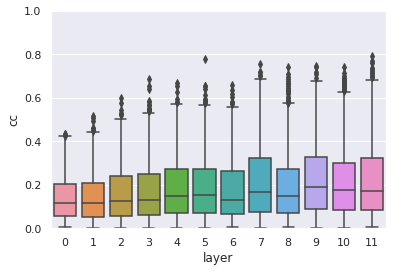

In [445]:
sns.boxplot(x="layer", y="cc", data=df_l4)
plt.ylim((0, 1))

(0.0, 1.0)

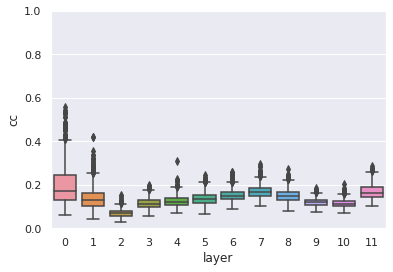

In [414]:
sns.boxplot(x="layer", y="cc", data=df_l4)
plt.ylim((0, 1))

In [462]:
act_norm_l4 = torch.norm(act_l4, dim=-1, p=2)
act_cosd_l4 = torch.einsum("...mc,...nc->...mn", act_l4, act_l4) / torch.einsum("...m,...n->...mn", act_norm_l4, act_norm_l4)

tril_mask = torch.tril(torch.ones(act_cosd_l4.shape[-2:], dtype=torch.bool), diagonal=-1)
act_trilcosd_l4 = act_cosd_l4[:, :, tril_mask]

In [463]:
act_avgcosd_l4 = act_cosd_l4.mean(1)

In [464]:
act_l4_normed = act_l4 / act_norm_l4[..., None]
act_bcosd_l4 = torch.einsum("lanc,lbnc->lnab", act_l4_normed, act_l4_normed)
act_avgbcosd_l4 = act_bcosd_l4.mean(1)

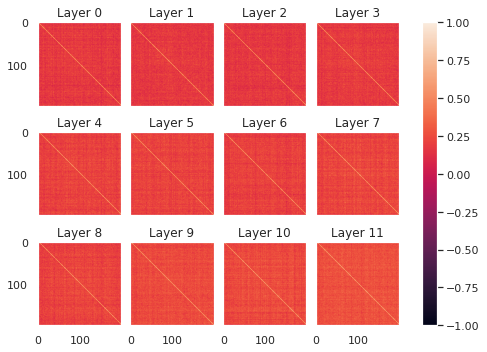

In [465]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgcosd_l4.shape[0]): 
    i, j = np.unravel_index(l, (3, 4))
    imsh = axs[i, j].imshow(act_avgcosd_l4[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l4.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

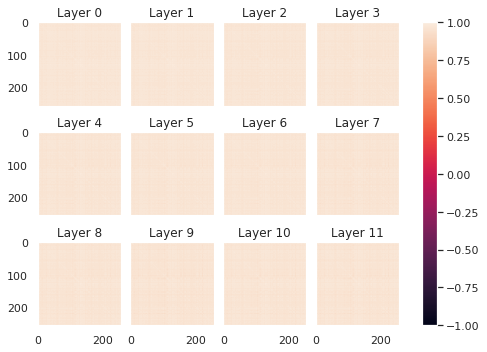

In [466]:
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(7, 5))
for l in range(act_avgbcosd_l4.shape[0]): 
    i, j = np.unravel_index(l, (3, 4))
    imsh = axs[i, j].imshow(act_avgbcosd_l4[l], vmin=-1, vmax=1)
    axs[i, j].grid(False)
    axs[i, j].set_title(f"Layer {l}")
# plt.imshow(act_cosd_l3.mean(1)[1], vmin=-1, vmax=1)
# plt.grid(False)
# plt.colorbar()
plt.tight_layout()
fig.colorbar(imsh, ax=axs)
plt.show()

In [383]:
pgrads_l4 = []

for b in range(len(vit.core.transformer.layers)): 
    pgrads_l4.append(get_grad_norm(vit.core.transformer.layers[b], True))

pgrads_l4 = torch.stack(pgrads_l4)

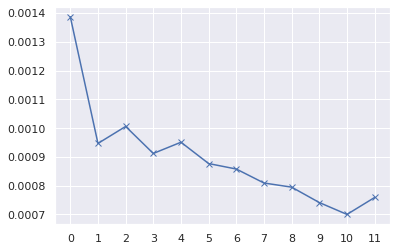

In [384]:
plt.figure()
plt.plot(list(range(pgrads_l4.shape[0])), pgrads_l4, marker="x")
plt.xticks(ticks=list(range(pgrads_l4.shape[0])))
plt.show()

In [88]:
vit.core.cls_token.shape

torch.Size([1, 1, 384])

In [91]:
vit_latent = torch.cat([eo.repeat(vit.core.cls_token[0], "... -> b ...", b=act_l4.shape[1]), 
                        vit_tracer.get("core.to_patch_embedding", "output")], dim=1)

In [93]:
with torch.no_grad():
    act_with_latent_l4 = torch.cat([vit_latent[None], act_l4], dim=0)
    act_diff_l4 = torch.diff(act_with_latent_l4, dim=0)

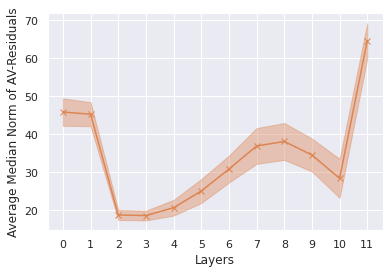

In [101]:
mu = act_diff_l4.norm(p=2, dim=-1).median(-1).values.mean(-1)
sig = act_diff_l4.norm(p=2, dim=-1).median(-1).values.std(-1)
ls = list(range(act_diff_l4.shape[0]))

cpal = sns.color_palette()

plt.figure()
plt.plot(ls, mu, c=cpal[1], marker="x")
plt.fill_between(ls, mu - sig, mu + sig, color=cpal[1], alpha=0.4)
plt.xticks(ls)
plt.xlabel("Layers")
plt.ylabel("Average Median Norm of AV-Residuals")
plt.show()

In [470]:
proj_mat_1d = torch.randn(384, 1)
projact_1d_l4 = (act_l4 @ proj_mat_1d)[..., 0]

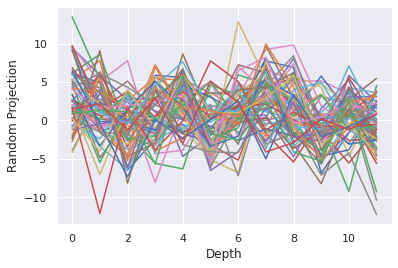

In [473]:
plt.figure()
for n in range(64): 
    plt.plot(projact_1d_l4[:, 0, n])
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

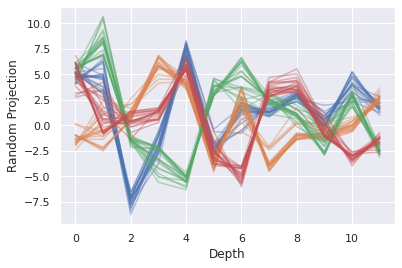

In [480]:
plt.figure()
for n in range(10, 14): 
    for b in range(20): 
        plt.plot(projact_1d_l4[:, b, n], c=cpal[n], alpha=0.4)
plt.xlabel("Depth")
plt.ylabel("Random Projection")
plt.show()

In [82]:
rich.print(list(vit_tracer.records.keys()))

[
    'core.to_patch_embedding.0',
    'core.to_patch_embedding.1',
    'core.to_patch_embedding',
    'core.dropout',
    'core.transformer.layers.0.0.norm',
    'core.transformer.layers.0.0.fn.to_qkv',
    'core.transformer.layers.0.0.fn.attend',
    'core.transformer.layers.0.0.fn.to_out.0',
    'core.transformer.layers.0.0.fn.to_out.1',
    'core.transformer.layers.0.0.fn.to_out',
    'core.transformer.layers.0.0.fn',
    'core.transformer.layers.0.0',
    'core.transformer.layers.0.1.norm',
    'core.transformer.layers.0.1.fn.net.0',
    'core.transformer.layers.0.1.fn.net.1',
    'core.transformer.layers.0.1.fn.net.2',
    'core.transformer.layers.0.1.fn.net.3',
    'core.transformer.layers.0.1.fn.net.4',
    'core.transformer.layers.0.1.fn.net',
    'core.transformer.layers.0.1.fn',
    'core.transformer.layers.0.1',
    'core.transformer.layers.1.0.norm',
    'core.transformer.layers.1.0.fn.to_qkv',
    'core.transformer.layers.1.0.fn.attend',
    'core.transformer.layers.1.0.fn.to_out.0',
    'core.transformer.layers.1.0.fn.to_out.1',
    'core.transformer.layers.1.0.fn.to_out',
    'core.transformer.layers.1.0.fn',
    'core.transformer.layers.1.0',
    'core.transformer.layers.1.1.norm',
    'core.transformer.layers.1.1.fn.net.0',
    'core.transformer.layers.1.1.fn.net.1',
    'core.transformer.layers.1.1.fn.net.2',
    'core.transformer.layers.1.1.fn.net.3',
    'core.transformer.layers.1.1.fn.net.4',
    'core.transformer.layers.1.1.fn.net',
    'core.transformer.layers.1.1.fn',
    'core.transformer.layers.1.1',
    'core.transformer.layers.2.0.norm',
    'core.transformer.layers.2.0.fn.to_qkv',
    'core.transformer.layers.2.0.fn.attend',
    'core.transformer.layers.2.0.fn.to_out.0',
    'core.transformer.layers.2.0.fn.to_out.1',
    'core.transformer.layers.2.0.fn.to_out',
    'core.transformer.layers.2.0.fn',
    'core.transformer.layers.2.0',
    'core.transformer.layers.2.1.norm',
    'core.transformer.layers.2.1.fn.net.0',
    'core.transformer.layers.2.1.fn.net.1',
    'core.transformer.layers.2.1.fn.net.2',
    'core.transformer.layers.2.1.fn.net.3',
    'core.transformer.layers.2.1.fn.net.4',
    'core.transformer.layers.2.1.fn.net',
    'core.transformer.layers.2.1.fn',
    'core.transformer.layers.2.1',
    'core.transformer.layers.3.0.norm',
    'core.transformer.layers.3.0.fn.to_qkv',
    'core.transformer.layers.3.0.fn.attend',
    'core.transformer.layers.3.0.fn.to_out.0',
    'core.transformer.layers.3.0.fn.to_out.1',
    'core.transformer.layers.3.0.fn.to_out',
    'core.transformer.layers.3.0.fn',
    'core.transformer.layers.3.0',
    'core.transformer.layers.3.1.norm',
    'core.transformer.layers.3.1.fn.net.0',
    'core.transformer.layers.3.1.fn.net.1',
    'core.transformer.layers.3.1.fn.net.2',
    'core.transformer.layers.3.1.fn.net.3',
    'core.transformer.layers.3.1.fn.net.4',
    'core.transformer.layers.3.1.fn.net',
    'core.transformer.layers.3.1.fn',
    'core.transformer.layers.3.1',
    'core.transformer.layers.4.0.norm',
    'core.transformer.layers.4.0.fn.to_qkv',
    'core.transformer.layers.4.0.fn.attend',
    'core.transformer.layers.4.0.fn.to_out.0',
    'core.transformer.layers.4.0.fn.to_out.1',
    'core.transformer.layers.4.0.fn.to_out',
    'core.transformer.layers.4.0.fn',
    'core.transformer.layers.4.0',
    'core.transformer.layers.4.1.norm',
    'core.transformer.layers.4.1.fn.net.0',
    'core.transformer.layers.4.1.fn.net.1',
    'core.transformer.layers.4.1.fn.net.2',
    'core.transformer.layers.4.1.fn.net.3',
    'core.transformer.layers.4.1.fn.net.4',
    'core.transformer.layers.4.1.fn.net',
    'core.transformer.layers.4.1.fn',
    'core.transformer.layers.4.1',
    'core.transformer.layers.5.0.norm',
    'core.transformer.layers.5.0.fn.to_qkv',
    'core.transformer.layers.5.0.fn.attend',
    'core.transformer.layers.5.0.fn.to_out.0',
    'core.transformer.layers.5.0.fn.to_out.1',
    'core.transformer.layers.5.0.fn.to_out',
    'core.transformer.layer

### Comparison Plots

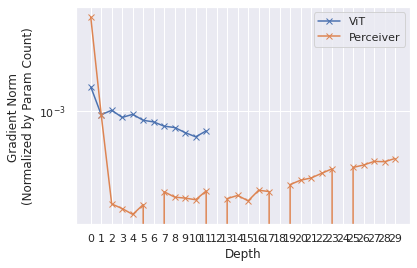

In [385]:
plt.figure()
plt.semilogy(list(range(pgrads_l4.shape[0])), pgrads_l4, marker="x", label="ViT")
plt.semilogy(list(range(pgrads_l2.shape[0])), pgrads_l2, marker="x", label="Perceiver")
plt.xticks(ticks=list(range(pgrads_l2.shape[0])))
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Gradient Norm \n(Normalized by Param Count)")
plt.show()

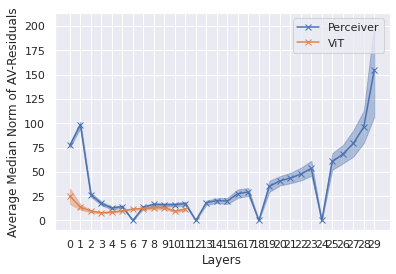

In [411]:
cpal = sns.color_palette()

plt.figure()

mu = act_diff_l1.norm(p=2, dim=-1).median(-1).values.mean(-1)
sig = act_diff_l1.norm(p=2, dim=-1).median(-1).values.std(-1)
ls = list(range(act_diff_l1.shape[0]))
plt.plot(ls, mu, c=cpal[0], marker="x", label="Perceiver")
plt.fill_between(ls, mu - sig, mu + sig, color=cpal[0], alpha=0.4)

mu = act_diff_l3.norm(p=2, dim=-1).median(-1).values.mean(-1)
sig = act_diff_l3.norm(p=2, dim=-1).median(-1).values.std(-1)
ls = list(range(act_diff_l4.shape[0]))
plt.plot(ls, mu, c=cpal[1], marker="x", label="ViT")
plt.fill_between(ls, mu - sig, mu + sig, color=cpal[1], alpha=0.4)

plt.xticks(range(act_diff_l1.shape[0]))
plt.xlabel("Layers")
plt.ylabel("Average Median Norm of AV-Residuals")
plt.legend()
plt.show()